In [37]:
import pandas as np
df = np.read_csv('mbti_1.csv')

# populating types array
types = []
for _type in df['type']:
     types.append(_type)


In [38]:
import pickle

tokenized_posts = []
with open ('tokenized_formatted_data.txt', 'rb') as fp:
    tokenized_posts = pickle.load(fp)

In [39]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)

In [40]:
from collections import Counter

In [41]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [42]:
dictionary = list(zip(*dictionary))[0]

In [43]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [44]:
x_vals = []
for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [45]:
temp = []
for i in range(0,8675):
    row = []
    row.append(types[i])
    row.append(x_vals[i])
    temp.append(row)

In [46]:
temp = sorted(temp)

In [47]:
x_train = []
y_train = []
x_test = []
y_test = []

In [48]:
types = []
x_vals = []
for i in range(0, 8675):
    types.append(temp[i][0])
    x_vals.append(temp[i][1])

In [49]:
current_type = types[0]
counter = 0
last_change = 0

for i in range(0, 8675):
    if types[i] != current_type or i == 8674:
        end_index = last_change + round(counter - counter/10)
        counter += last_change
        
        if (i == 8674):
            counter += 1
        
        for j in range(last_change, end_index):
            x_train.append(x_vals[j])
            y_train.append(types[j])
        
        for j in range(end_index, counter):
            x_test.append(x_vals[j])
            y_test.append(types[j])
        
        last_change = i
        counter = 1
        current_type = types[i]
        continue
    counter += 1
        

In [50]:
type_dictionary = {
    '0000':'INTJ',
    '0001':'INTP',
    '0010':'INFJ',
    '0011':'INFP',
    '0100':'ISTJ',
    '0101':'ISTP',
    '0110':'ISFJ',
    '0111':'ISFP',
    '1000':'ENTJ',
    '1001':'ENTP',
    '1010':'ENFJ',
    '1011':'ENFP',
    '1100':'ESTJ',
    '1101':'ESTP',
    '1110':'ESFJ',
    '1111':'ESFP',
}

type_labels=['INTJ','INTP','INFJ','INFP','ISTJ','ISTP','ISFJ','ISFP', \
        'ENTJ','ENTP','ENFJ','ENFP','ESTJ','ESTP','ESFJ','ESFP',]

def to_one_hot(arr):
    one_hot_types = []

    for label in arr:
        bin_type = []

        if (label[0] == 'I'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[1] == 'N'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[2] == 'T'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[3] == 'J'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        one_hot_types.append(bin_type)
        
    return one_hot_types
    

In [51]:
import numpy as np
from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

y_train = np.asarray(to_one_hot(y_train)).astype('float32')
y_test = np.asarray(to_one_hot(y_test)).astype('float32')



In [83]:
class_weights = {
    0:1.,
    1:3.43,
    2:1.,
    3:5.35,
    4:1.,
    5:1.12,
    6:1.,
    7:0.69
}

In [53]:
# FEED FORWARD MODEL
from keras import models
from keras import layers
from keras import regularizers
import tensorflow as tf
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                           activation='relu', input_shape = (10000,)))
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                           activation='relu'))
    model.add(layers.Dense(4, activation='sigmoid'))
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])
    return model

In [81]:
model = build_model()
with tf.device('/gpu:0'):
    history = model.fit(x_train, y_train, epochs = 15, batch_size = 256, class_weight=class_weights)
    y_pred = model.predict(x_test)
    results = model.evaluate(x_test, y_test)
results

Epoch 1/15
7806/7806 [==============================] - 1s 189us/step - loss: 1.2365 - acc: 0.6616
Epoch 2/15
7806/7806 [==============================] - 1s 112us/step - loss: 1.0693 - acc: 0.7108
Epoch 3/15
7806/7806 [==============================] - 1s 102us/step - loss: 0.9232 - acc: 0.7325
Epoch 4/15
7806/7806 [==============================] - 1s 102us/step - loss: 0.8184 - acc: 0.7464
Epoch 5/15
7806/7806 [==============================] - 1s 100us/step - loss: 0.7315 - acc: 0.7735
Epoch 6/15
7806/7806 [==============================] - 1s 102us/step - loss: 0.6663 - acc: 0.7979
Epoch 7/15
7806/7806 [==============================] - 1s 99us/step - loss: 0.6138 - acc: 0.8221
Epoch 8/15
7806/7806 [==============================] - 1s 99us/step - loss: 0.5745 - acc: 0.8362
Epoch 9/15
7806/7806 [==============================] - 1s 97us/step - loss: 0.5397 - acc: 0.8541
Epoch 10/15
7806/7806 [==============================] - 1s 99us/step - loss: 0.5152 - acc: 0.8635
Epoch 11/15
7

[0.6516792054006227, 0.7540276178830787]

Normalized confusion matrix


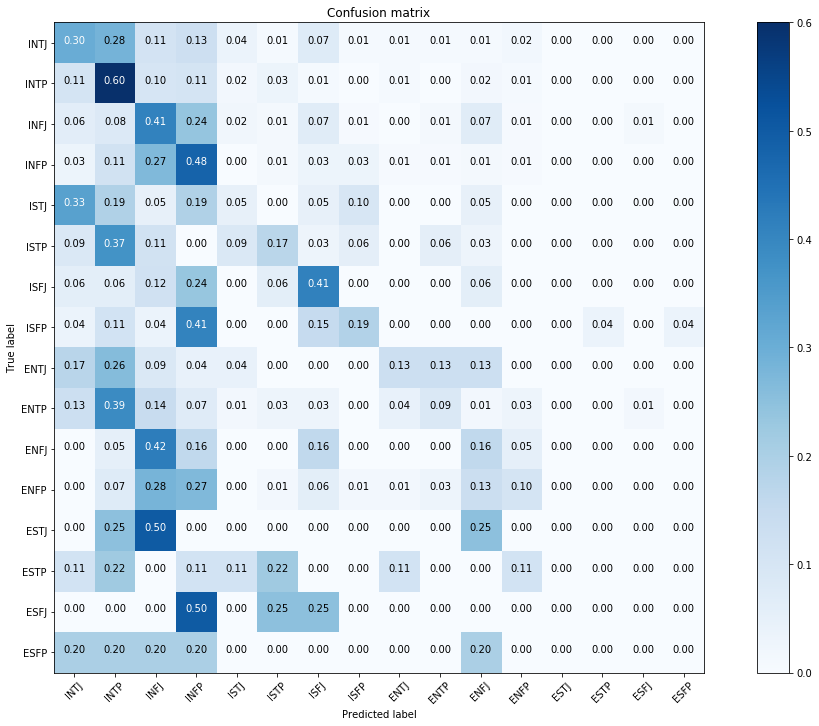

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

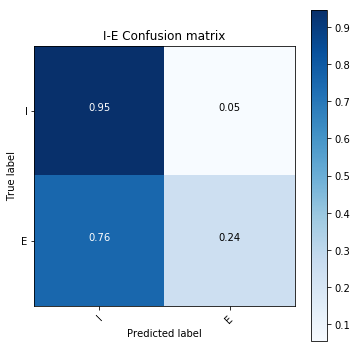

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

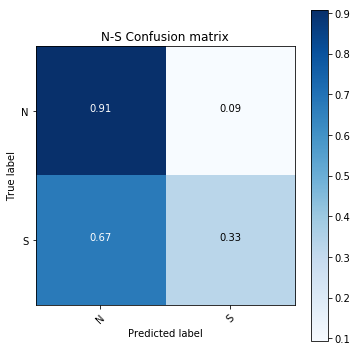

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

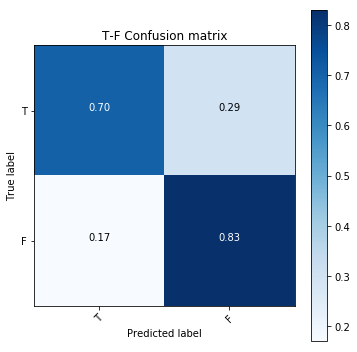

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

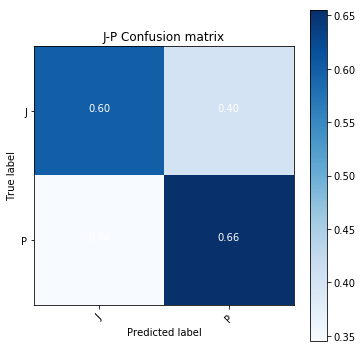

In [82]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import datetime

now = datetime.datetime.now()
pictures = []
folder = "FF"

def byte_to_mbti(byte):
    binary = ''
    for letter in byte:
         binary +=(str(int(letter)))        
    return type_dictionary[binary]

decoded_y_true = [byte_to_mbti(label) for label in y_test.round()]
decoded_y_pred = [byte_to_mbti(label) for label in y_pred.round()]

matrix = confusion_matrix(decoded_y_true, decoded_y_pred, labels=type_labels)
matrix_I_E = confusion_matrix(y_test[:,0], y_pred[:,0].round(), labels=[0, 1])
matrix_N_S = confusion_matrix(y_test[:,1], y_pred[:,1].round(), labels=[0, 1])
matrix_T_F = confusion_matrix(y_test[:,2], y_pred[:,2].round(), labels=[0, 1])
matrix_J_P = confusion_matrix(y_test[:,3], y_pred[:,3].round(), labels=[0, 1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(15,10))
plot_confusion_matrix(matrix, classes=type_labels, normalize=True,
                      title='Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM0.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_I_E, classes=["I", "E"], normalize=True,
                      title='I-E Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM1.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_N_S, classes=["N", "S"], normalize=True,
                      title='N-S Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM2.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_T_F, classes=["T", "F"], normalize=True,
                      title='T-F Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM3.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_J_P, classes=["J", "P"], normalize=True,
                      title='J-P Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM4.png"
plt.savefig(name)
plt.show()
pictures.append(name)

In [74]:
def myprint(s):
    with open('results.log','a+') as f:
        print(s, file=f)
    f.close()
        
log_file = open('results.log', 'a+')

log_file.write("\n=================================================================")
log_file.write( "\n" + str(now.month) + "/" + str(now.day) + "/" + str(now.year) + " " + \
str(now.hour) + ":" + str(now.minute) + ":" + str(now.second) + "\n")

log_file.close()

model.summary(print_fn=myprint)

log_file = open('results.log', 'a+')

log_file.write("Results:\t" + str(results) + "\n")

log_file.write("Images:\n")
log_file.write("\t" + pictures[0] + "\n")
log_file.write("\t" + pictures[1] + "\n")
log_file.write("\t" + pictures[2] + "\n")
log_file.write("\t" + pictures[3] + "\n")
log_file.write("\t" + pictures[4] + "\n")

log_file.close()